---
# Map of model domain and locations
---

In [1]:
import os
import numpy
import pandas
import xarray
import yaml
import netCDF4 as nc
import cartopy.crs
import cmocean
#import rioxarray
from array import *
from cmocean import cm as cmo
from glob import glob
from cartopy import crs,feature
import matplotlib as mpl
from matplotlib import pyplot as plt, patches, colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pathlib import Path
# used to make subplot labels consistent between figures
from matplotlib.offsetbox import AnchoredText
#from salishsea_tools import geo_tools, tidetools
import sys
sys.path.insert(0, '../../scripts')
from monte_carlo_utils import assign_facility_region

In [2]:
if os.sys.platform=="darwin":
    grid_dir = Path('/Volumes/Elements/MIDOSS_Data')
    topo_dir = Path('/Volumes/Elements/MIDOSS_Data')
    graphics_dir = Path('/Users/rmueller/Projects/MIDOSS/Publications/MIDOSS_MuellerEtAl/JGR_graphics')
    yaml_input = Path(
        '/Users/rmueller/Data/MIDOSS/marine_transport_data'
    )
    facilities_xlsx = Path('/Users/rmueller/Data/MIDOSS/marine_transport_data/Oil_Transfer_Facilities.xlsx')
    ecy_data  = Path('/Users/rmueller/Data/MIDOSS/DeptOfEcology/MuellerTrans4-30-20.xlsx')
    fac_names = Path('/Users/rmueller/Data/MIDOSS/marine_transport_data/Oil_Transfer_Facilities.xlsx')
else:
    grid_dir = Path('/data/bmoorema/MEOPAR/grid/')
    topo_dir = Path('/ocean/bmoorema/research/MEOPAR/analysis-ben/data/')
    graphics_dir = Path('/ocean/rmueller/MIDOSS/graphics/')
    yaml_input = Path('/data/MIDOSS/marine_transport_data/')
    facilities_xlsx = Path('/data/MIDOSS/marine_transport_data/Oil_Transfer_Facilities.xlsx')
    ecy_data  = Path('/data/MIDOSS/spreadsheets/MuellerTrans4-30-20.xlsx')
    fac_names = Path('/data/MIDOSS/marine_transport_data/Oil_Transfer_Facilities.xlsx')
    #geotiff_directory = Path('/data/MIDOSS/geotiffs')

In [3]:
# larger, presentation-size graphics require different xy text specifications
graphics_size='large'
if graphics_size=='large':
    # graphics style
    plt.style.use(r"../../style_templates/JGR2023_matplotlibrc.template")
    
# mapping specifications
rotated_crs = cartopy.crs.RotatedPole(pole_longitude=120.0, pole_latitude=63.75)
plain_crs = cartopy.crs.PlateCarree()
# linewidth for coast/rivers
lw=0.3
# reducd dpi to make smaller graphics
custom_dpi=600

## specify crude oil transfer marine terminal locations 

In [4]:
from monte_carlo_utils import get_ECY_df
crude_products = ["BAKKEN","CRUDE OIL","BITUMEN OIL (DIL OR SYN)"]

ECYdf=get_ECY_df(
    ecy_data, 
    fac_names,  
    group='no'
)

# imports
print("~~~ CRUDE IMPORT TERMINALS ~~~ ")
for idx,crude in enumerate(crude_products):
    import_df = ECYdf[(ECYdf['Product']==crude_products[idx]) & (ECYdf["ReceiverTypeDescription"]=="Facility")]
    print(
        crude,
        import_df.groupby('Receiver').count().index.to_list(), # terminal(s)
        import_df.groupby('DelivererTypeDescription').count().AntID # vessel type(s)
    ) 
    
# exports
print("\n\n~~~ CRUDE EXPORT TERMINALS ~~~ ")
for idx,crude in enumerate(crude_products):
    export_df = ECYdf[(ECYdf['Product']==crude_products[idx]) & (ECYdf["DelivererTypeDescription"]=="Facility")]
    print(
        crude,
        export_df.groupby('Deliverer').count().index.to_list(), # terminal(s)
        #export_df.groupby('ReceiverTypeDescription').count().index.to_list(), # vessel type(s)
        export_df.groupby('ReceiverTypeDescription').count().AntID, # vessel type(s)
    )

~~~ CRUDE IMPORT TERMINALS ~~~ 
BAKKEN ['BP Cherry Point Refinery'] DelivererTypeDescription
TANK BARGE    1
Name: AntID, dtype: int64
CRUDE OIL ['BP Cherry Point Refinery', 'Clean Harbors Inc.', 'Marathon Anacortes Refinery (formerly Tesoro)', 'Phillips 66 Ferndale Refinery', 'Shell', 'Shell Puget Sound Refinery', 'U.S. Oil & Refining'] DelivererTypeDescription
TANK BARGE              13
TANK SHIP              268
Un-regulated Vessel      4
Name: AntID, dtype: int64
BITUMEN OIL (DIL OR SYN) [] Series([], Name: AntID, dtype: int64)


~~~ CRUDE EXPORT TERMINALS ~~~ 
BAKKEN [] Series([], Name: AntID, dtype: int64)
CRUDE OIL ['BP Cherry Point Refinery', 'Marathon Anacortes Refinery (formerly Tesoro)', 'Shell Puget Sound Refinery', 'U.S. Oil & Refining'] ReceiverTypeDescription
TANK BARGE    11
TANK SHIP     19
Name: AntID, dtype: int64
BITUMEN OIL (DIL OR SYN) ['Alon Asphalt Company (Paramount Petroleum)', 'SeaPort Sound Terminal'] ReceiverTypeDescription
TANK BARGE    6
Name: AntID, dtyp

In [5]:
# Removing "Clean Harbors" b/c transfers are "Vacuum", not Cargo
ECYdf[(ECYdf['Product']=="CRUDE OIL") & (ECYdf['Receiver']=='Clean Harbors Inc.')]

,AntID,StartDateTime,Deliverer,Receiver,Product,TransferQtyInGallon,TransferType,DelivererTypeDescription,ReceiverTypeDescription,ImportRegion,ExportRegion
12375,184826,2018-10-20 07:00:00,ATB BARGE KIRBY 185-01,Clean Harbors Inc.,CRUDE OIL,12000.0,Vacuum,TANK BARGE,Facility,not attributed,not attributed
12435,184885,2018-10-22 08:30:00,ATB BARGE DBL 185-01,Clean Harbors Inc.,CRUDE OIL,6000.0,Vacuum,Un-regulated Vessel,Facility,not attributed,not attributed
12526,184969,2018-10-24 10:30:00,ATB BARGE KIRBY 185-01,Clean Harbors Inc.,CRUDE OIL,13000.0,Vacuum,TANK BARGE,Facility,not attributed,not attributed


In [6]:
# Remove "Shell" b/c there is only one entry and is likely the same as 'Shell Puget Sound Refinery'
#ECYdf[ECYdf["ReceiverTypeDescription"]=="Facility"].groupby("Receiver").count()

In [7]:
# # This shows that the 4 transfers by un-regulated vessels are on-off transfers 
# # One of the vessels ("POLAR ENTERPRISE") is registered as "TANK SHIP" for all other transfers in the region
# # The use of "un-regulated" vessel description appears to be a data entry error
# print("Which ship(s) is an unregulated vessel?")
# for idx,crude in enumerate(crude_products):
#     print(crude_products[idx])
#     print("\t",
#         DOEdf[
#             (DOEdf['Product']==crude_products[idx]) & 
#             (DOEdf["DelivererTypeDescription"]=="Un-regulated Vessel")
#         ].groupby("Deliverer").count().AntID
#     )

# un_reg_vessel_list = DOEdf[
#             (DOEdf['Product']==crude_products[1]) & 
#             (DOEdf["DelivererTypeDescription"]=="Un-regulated Vessel")
#         ].groupby("Deliverer").count().index.to_list()

# print("\n\nAre these ships always classified as unregulated?")
# for vessel in un_reg_vessel_list:
#     print(DOEdf[(DOEdf["Deliverer"]==vessel)].groupby("DelivererTypeDescription").count().index.to_list()) 
        
# print("\n\nHow are these ship(s) used?")
# print("Deliverer","Receiver","TransferQtyInGallon")
# for vessel in un_reg_vessel_list[0:3]: 
#     print(
#         DOEdf[(DOEdf["Deliverer"]==vessel) & (DOEdf.TransferType == "Cargo")]["Deliverer"].to_list(),
#         DOEdf[(DOEdf["Deliverer"]==vessel) & (DOEdf.TransferType == "Cargo")]["Receiver"].to_list(),
#         DOEdf[(DOEdf["Deliverer"]==vessel) & (DOEdf.TransferType == "Cargo")]["TransferQtyInGallon"].to_list()
    
#     )

In [8]:
# open oil_attribution.yaml for paths
oil_attribution_file = yaml_input / 'oil_attribution.yaml'
with open(oil_attribution_file) as file:
            oil_attrs = yaml.load(file, Loader=yaml.Loader) 
US_facilities = oil_attrs['categories']['US_origin_destination']
CAD_facilities = oil_attrs['categories']['CAD_origin_destination']
#fac_df = assign_facility_region(fac_names)

# Facility information 
facdf={}
facdf['wa'] = pandas.read_excel(
    facilities_xlsx,
    sheet_name = 'Washington',
    usecols="B,J,K"
)
facdf['bc'] = pandas.read_excel(
    facilities_xlsx,
    sheet_name = 'British Columbia',
    usecols="A,B,C"
)  

In [51]:
# create list lats/lons for WA import and export terminals
fac_crude_in=['Phillips 66 Ferndale Refinery']
fac_crude_out=['Alon Asphalt Company (Paramount Petroleum)', 'SeaPort Sound Terminal']
fac_crude_both=['BP Cherry Point Refinery', 'Marathon Anacortes Refinery (formerly Tesoro)','Shell Puget Sound Refinery',  'U.S. Oil & Refining']
# export and import
fac_crude_both_lats = [facdf['wa'][facdf['wa']["FacilityName"]==facility].DockLatNumber.item() for facility in fac_crude_both]
fac_crude_both_lons = [facdf['wa'][facdf['wa']["FacilityName"]==facility].DockLongNumber.item() for facility in fac_crude_both]
# export-only
fac_crude_out_lats = [facdf['wa'][facdf['wa']["FacilityName"]==facility].DockLatNumber.item() for facility in fac_crude_out]
fac_crude_out_lons = [facdf['wa'][facdf['wa']["FacilityName"]==facility].DockLongNumber.item() for facility in fac_crude_out]

fac_crude_out_lons

[-122.398, -122.389]

In [10]:
facdf['bc'].Latitude[7]

49.289402

In [11]:
mask = xarray.open_dataset(grid_dir/'mesh_mask201702.nc')
coords = xarray.open_dataset(grid_dir/'coordinates_seagrid_SalishSea201702.nc', decode_times=False)
bathy = xarray.open_dataset(grid_dir/'bathymetry_201702.nc')
topo = xarray.open_dataset(topo_dir/'ETOPO1_Bed_g_gmt4.grd')
#spills = pandas.read_csv('/data/sallen/results/MIDOSS/Monte_Carlo/northern_strait.csv')

# Crop to Salish Sea
extent = [-126.5, -121.2, 46.8, 51.2]
topo_salishsea = topo.sel(x=slice(*extent[:2]), y=slice(*extent[2:]))
lon, lat = [coords[var][0, ...].values for var in ('glamt', 'gphit')]
#lon, lat, depth = [topo_salishsea[var].values for var in ('x', 'y', 'z')]
tmask = mask.tmask[0, 0, ...].values

In [37]:
# Annotations
if graphics_size=='large':
    annotations_coarse = [
        {'name': 'Model Domain'        , 'xy': (0.43, 0.80), 'f':12, 'r':-60,     'fs':'normal', 'wt': 'bold', 'arrow': None, 'ha':'left','alpha':0.4},
        {'name': 'Pacific\nOcean'      , 'xy': (0.100, 0.20), 'f':15, 'r':0,      'fs':'normal', 'wt': 'bold', 'arrow': None, 'ha':'left','alpha':None},
        {'name': 'Puget\nSound'        , 'xy': (0.81, 0.20), 'f':15, 'r':0,       'fs':'normal', 'wt': 'bold', 'arrow': None, 'ha':'left','alpha':None},
        {'name': 'Orcas\nIs'           , 'xy': (0.68, 0.395), 'f':9, 'r': 0,     'fs':'normal', 'wt': 'bold', 'arrow': None, 'ha':'center','alpha':None},
        {'name': 'Juan de Fuca\nStrait', 'xy': (0.45, 0.30), 'f':12, 'r': -20,   'fs':'italic', 'wt': 'normal', 'arrow': None, 'ha':'center','alpha':None},
        {'name': 'Haro Strait'         , 'xy': (0.62, 0.34), 'f':11, 'r': -70,   'fs':'italic', 'wt': 'normal', 'arrow': None, 'ha':'center','alpha':None},
        {'name': 'Johnstone\nStrait'   , 'xy': (0.13, 0.72),'f':12,  'r': -20,   'fs':'italic', 'wt': 'normal', 'arrow': None, 'ha':'center','alpha':None},
        {'name': 'Fraser\nRiver'       , 'xy': (0.855, 0.470), 'f':15, 'r': 0,  'fs':'normal', 'wt': 'bold', 'arrow': None, 'ha':'left','alpha':None},
        {'name': 'Boundary Pass'       , 'xy': (0.82, 0.44), 'f':12, 'r': 0,    'fs':'normal', 'wt': 'bold', 'arrow': (0.73, 0.44,  -0.03,  0.0), 'ha':'center','alpha':None},
        {'name': 'Turn Point'          , 'xy': (0.49, 0.44), 'f':12, 'r': 0,    'fs':'normal', 'wt': 'bold', 'arrow': (0.56, 0.445,  0.02,  -0.01),'ha':'center','alpha':None},     
        #{'name': 'Boundary Pass'       , 'xy': (0.800, 0.42), 'f':12, 'r':   0, 'fs':'italic', 'wt': 'normal', 'arrow': (0.75, 0.44,  -0.03,  0.0), 'ha':'center','alpha':None},
        #{'name': 'Boundary Pass'       , 'xy': (0.800, 0.38), 'f':12, 'r':   0, 'fs':'italic', 'wt': 'normal', 'arrow': (0.8, 0.4,  -0.03,  0.0), 'ha':'center','alpha':None},
        {'name': 'Strait of\nGeorgia'  , 'xy': (0.735, 0.585), 'f':12, 'r':   0, 'fs':'italic', 'wt': 'normal', 'arrow': (0.665, 0.59,  -0.065,  -0.03), 'ha':'center','alpha':None},
    ]
    annotations_fine = [
        {'name': '1', 'xy': (0.622,0.25), 'r':0, 'wt': 'bold', 'arrow': None, 'ha':'left','alpha':0.6},
        {'name': '2', 'xy': (0.29,0.39), 'r':0, 'wt': 'bold', 'arrow': None, 'ha':'left','alpha':0.6},
        {'name': '3', 'xy': (0.477,0.43), 'r':0, 'wt': 'bold', 'arrow': None, 'ha':'left','alpha':0.6},
        {'name': '4', 'xy': (0.345,0.57), 'r':0, 'wt': 'bold', 'arrow': None, 'ha':'left','alpha':0.6},
        {'name': '5', 'xy': (0.75,0.445), 'r':0, 'wt': 'bold', 'arrow': None, 'ha':'left','alpha':0.6},
    ]
else:
    annotations_coarse = [
        {'name': 'Model Domain'        , 'xy': (0.41, 0.78), 'r':   -60, 'wt': 'bold', 'arrow': None, 'ha':'left','alpha':0.4},
        {'name': 'Pacific\nOcean'      , 'xy': (0.100, 0.200), 'r':   0, 'wt': 'bold', 'arrow': None, 'ha':'left','alpha':None},
        {'name': 'Puget\nSound'        , 'xy': (0.810, 0.180), 'r':   0, 'wt': 'bold', 'arrow': None, 'ha':'left','alpha':None},
        {'name': 'Juan de Fuca\nStrait', 'xy': (0.475, 0.26), 'r': -17, 'wt': 'bold', 'arrow': None, 'ha':'center','alpha':None},
        {'name': 'Johnstone\nStrait'   , 'xy': (0.11, 0.717), 'r': -20, 'wt': 'bold', 'arrow': None, 'ha':'center','alpha':None},
        {'name': 'Fraser\nRiver'       , 'xy': (0.855, 0.470), 'r':   0, 'wt': 'bold', 'arrow': None, 'ha':'left','alpha':None},
        {'name': 'Strait of\nGeorgia'  , 'xy': (0.75, 0.6), 'r':   0, 'wt': 'bold', 'arrow': (0.665, 0.59,  -0.065,  -0.03), 'ha':'center','alpha':None},
    ]
    

In [75]:
dx = 0.025
dy = 0.025
annotations_facility = [
    {'name': '1', 'xy': (facdf['bc'].Longitude[7],facdf['bc'].Latitude[7]+dy), 'f':12, 'fs':'normal', 'wt': 'bold'},
    {'name': '2', 'xy': (fac_crude_both_lons[0]+dy, fac_crude_both_lats[0]+dy), 'f':12, 'fs':'normal', 'wt': 'bold'},
    {'name': '3', 
     'xy': (facdf['wa'][facdf['wa']["FacilityName"]=='Phillips 66 Ferndale Refinery'].DockLongNumber.item()+2*dx,
    facdf['wa'][facdf['wa']["FacilityName"]=='Phillips 66 Ferndale Refinery'].DockLatNumber.item()+dy), 
     'f':12, 'fs':'normal', 'wt': 'bold'},
    {'name': '4,5', 'xy': (fac_crude_both_lons[2]+2*dx, fac_crude_both_lats[2]-dy), 'f':12, 'fs':'normal', 'wt': 'bold'},
    {'name': '6', 'xy': (fac_crude_out_lons[0]+2*dx,fac_crude_out_lats[0]-dy), 'f':12, 'fs':'normal', 'wt': 'bold'},
    {'name': '7,8', 'xy': (fac_crude_out_lons[1]+dx,fac_crude_out_lats[1]), 'f':12, 'fs':'normal', 'wt': 'bold'}
]

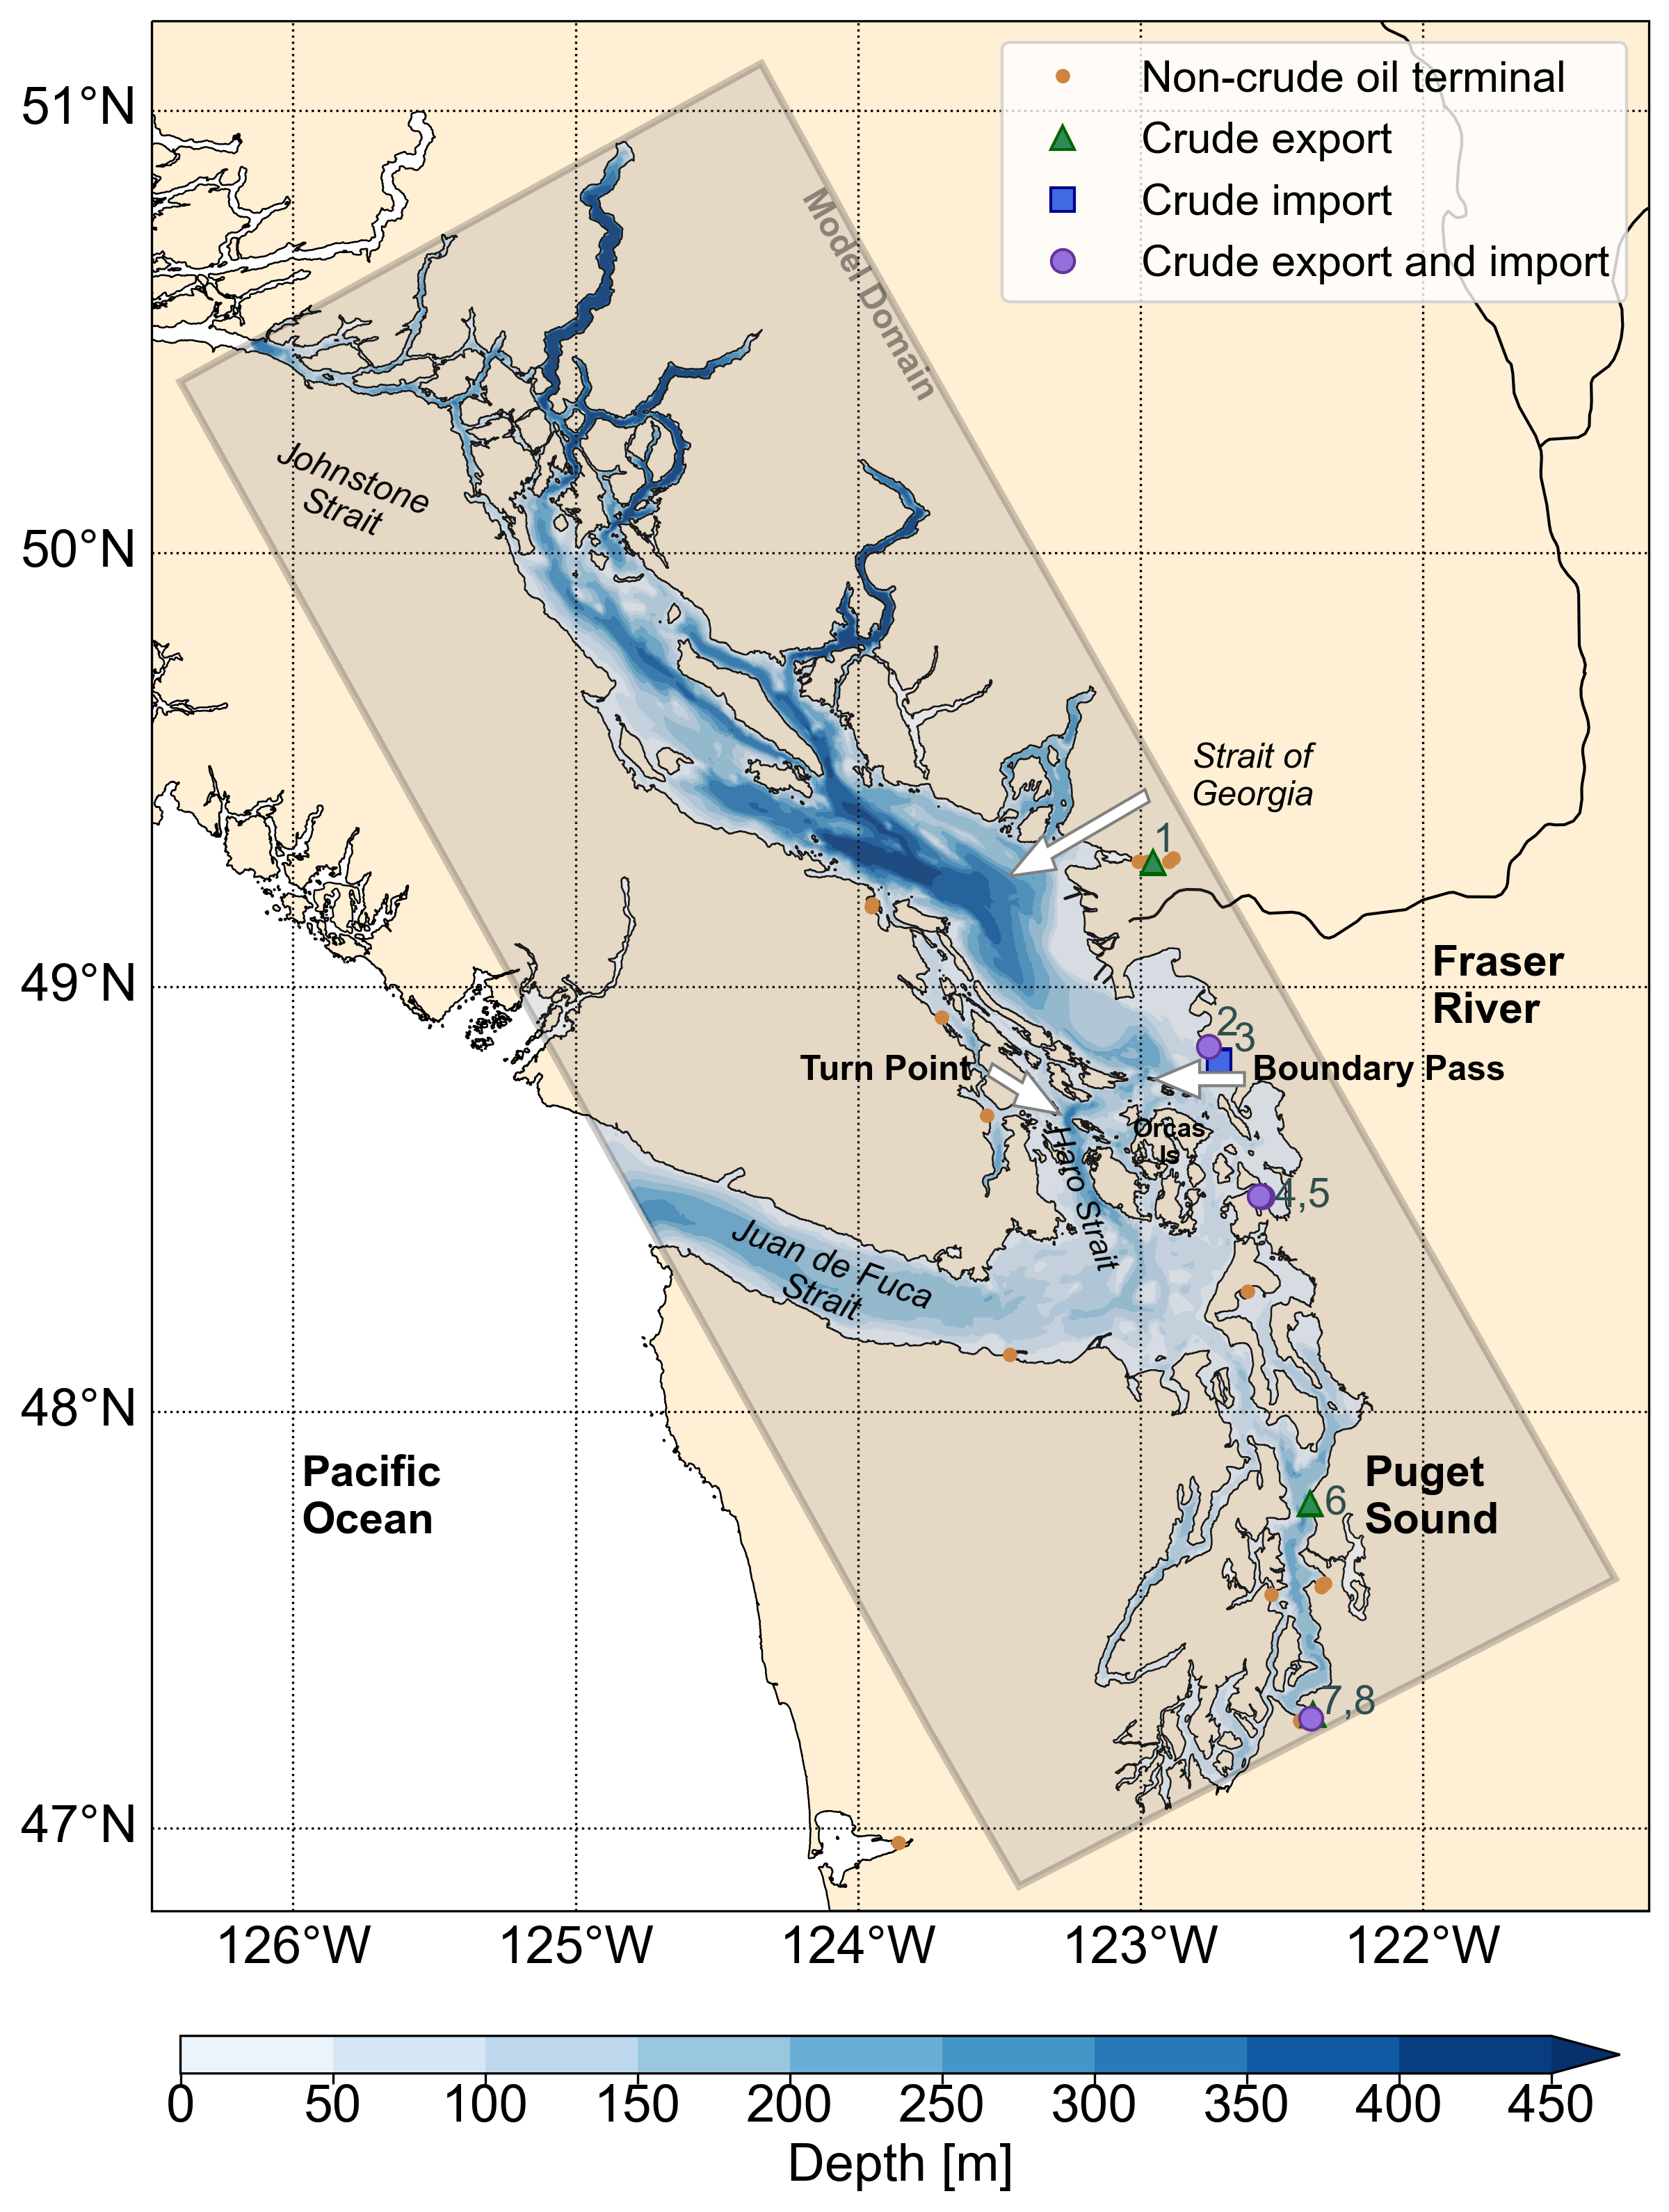

In [76]:
# The code for this figure is a modified version of code from Ben Moore-Maley
# --------- Figure setup ---------
proj_ref = crs.PlateCarree()
fig = plt.figure(figsize=(30, 12))
gs = plt.GridSpec(1, 3, wspace=0.05)

# --------- Left panel -----------
# Make map
extent = [-126.5, -121.2, 46.8, 51.2]
proj = crs.Mercator(numpy.mean(extent[:2]), *extent[2:])
ax = fig.add_subplot(gs[0], projection=proj)
ax.set_extent(extent)
ax.add_feature(feature.GSHHSFeature('full', edgecolor='k', linewidth=0.6, facecolor='papayawhip'))
ax.add_feature(feature.NaturalEarthFeature(
    category='physical', name='rivers_lake_centerlines',
    scale='10m', facecolor='none', edgecolor='k',
))
gl = ax.gridlines(linestyle=":", color='k', draw_labels=True)
gl.top_labels, gl.right_labels = False, False

# Overlay model domain
domain_box = numpy.array([(lon[ji], lat[ji]) for ji in [(0, 0), (0, -1), (-1, -1), (-1, 0)]])
c = ax.contourf(lon, lat, bathy.Bathymetry, levels=numpy.arange(0, 451, 50), cmap='Blues', extend='max', transform=proj_ref)
ax.add_patch(patches.Polygon(domain_box, ec='k', fc='gray', lw=2.5, alpha=0.2, transform=proj_ref, zorder=2))
#ax.add_patch(patches.Rectangle((-125.3, 49.1), 1.5, 1.2, fc='w', ec='k', alpha=0.5, lw=2.5, transform=proj_ref, zorder=2))


# plot all oil transfer terminals
ax.plot(
    pandas.concat([facdf['wa'].DockLongNumber,facdf['bc'].Longitude[0:10]]) ,
    pandas.concat([facdf['wa'].DockLatNumber,facdf['bc'].Latitude[0:10]]) ,
    'o', 
    color='peru', 
    markersize=4, 
    label="Non-crude oil terminal",
    transform=proj_ref
)

# plot location of crude-export only 
ax.plot(
    facdf['bc'].Longitude[7],
    facdf['bc'].Latitude[7],
    '^', 
    color='seagreen', 
    markeredgecolor='darkgreen', 
    markersize=8, 
    label="Crude export ",
    transform=proj_ref
)
ax.plot(
    fac_crude_out_lons,
    fac_crude_out_lats,
    '^', 
    color='seagreen', 
    markeredgecolor='darkgreen', 
    markersize=8, 
    transform=proj_ref
)

# plot location of crude-import only (P66)
ax.plot(
    facdf['wa'][facdf['wa']["FacilityName"]=='Phillips 66 Ferndale Refinery'].DockLongNumber.item(),
    facdf['wa'][facdf['wa']["FacilityName"]=='Phillips 66 Ferndale Refinery'].DockLatNumber.item(),
    's', 
    color='royalblue', 
    markeredgecolor='darkblue', 
    markersize=8, 
    label="Crude import",
    transform=proj_ref
)

# plot crude-import and crude-export locations
ax.plot(
    fac_crude_both_lons,
    fac_crude_both_lats,
    'o', 
    color='mediumpurple', 
    markeredgecolor='rebeccapurple', 
    markersize=8,
    label="Crude export and import",
    transform=proj_ref
)

# Add legend
ax.legend(bbox_to_anchor=(1, 1), loc='upper right')

for ann in annotations_facility:
    ax.text(*ann['xy'], ann['name'], 
                transform=proj_ref, 
                fontsize=14,
                fontdict={'weight': 2, 'color': 'darkslategrey'},
               )
# Annotations
for ann in annotations_coarse:
    if ann['alpha'] is not None:
        ax.text(*ann['xy'], ann['name'], 
                transform=ax.transAxes, 
                rotation=ann['r'],
                fontsize=ann['f'],
                fontdict={'weight': ann['wt'], 'color': 'k'},
                ha=ann['ha'],
                alpha=ann['alpha']
               )
    else:
        ax.text(*ann['xy'], ann['name'], 
                transform=ax.transAxes, 
                rotation=ann['r'], 
                fontsize=ann['f'],
                style=ann['fs'],
                fontdict={'weight': ann['wt'], 'color': 'k'},
                ha=ann['ha']
               )
    if ann['arrow'] is not None:
        ax.arrow(*ann['arrow'], width=0.007, head_width=0.02, edgecolor='grey', facecolor='white', transform=ax.transAxes, zorder=10)

# Colorbar
cax = fig.add_axes([0.135, 0.06, 0.23, 0.015])
fig.colorbar(c, cax=cax, orientation='horizontal', label='Depth [m]')

# save figure
if custom_dpi>=600:
    plt.savefig(graphics_dir/'Figure1_SSC_model_domain.png')
else:
    plt.savefig(graphics_dir/'Figure1_SSC_model_domain_small.png')
 

# Map with Westridge Marine Terminal

In [ ]:
# The code for this figure is a modified version of code from Ben Moore-Maley
# --------- Figure setup ---------
proj_ref = crs.PlateCarree()
fig = plt.figure(figsize=(30, 12))
gs = plt.GridSpec(1, 3, wspace=0.05)

# --------- Left panel -----------
# Make map
extent = [-126.5, -121.2, 46.8, 51.2]
proj = crs.Mercator(numpy.mean(extent[:2]), *extent[2:])
ax = fig.add_subplot(gs[0], projection=proj)
ax.set_extent(extent)
ax.add_feature(feature.GSHHSFeature('full', edgecolor='k', linewidth=0.6, facecolor='papayawhip'))
ax.add_feature(feature.NaturalEarthFeature(
    category='physical', name='rivers_lake_centerlines',
    scale='10m', facecolor='none', edgecolor='k',
))
gl = ax.gridlines(linestyle=":", color='k', draw_labels=True)
gl.top_labels, gl.right_labels = False, False

# Overlay model domain
domain_box = numpy.array([(lon[ji], lat[ji]) for ji in [(0, 0), (0, -1), (-1, -1), (-1, 0)]])
c = ax.contourf(lon, lat, bathy.Bathymetry, levels=numpy.arange(0, 451, 50), cmap='Blues', extend='max', transform=proj_ref)
ax.add_patch(patches.Polygon(domain_box, ec='k', fc='gray', lw=2.5, alpha=0.2, transform=proj_ref, zorder=2))
#ax.add_patch(patches.Rectangle((-125.3, 49.1), 1.5, 1.2, fc='w', ec='k', alpha=0.5, lw=2.5, transform=proj_ref, zorder=2))


# plot WA terminal locations and legend marker
ax.plot(
    facdf['wa'].DockLongNumber,
    facdf['wa'].DockLatNumber,
    's', 
    color='seagreen', 
    markeredgecolor='darkgreen', 
    markersize=5, 
    transform=proj_ref
)

# plot BC terminal locations and legend marker
ax.plot(
    facdf['bc'].Longitude,
    facdf['bc'].Latitude,
    'o', 
    color='royalblue', 
    markeredgecolor='darkblue', 
    markersize=5, 
    transform=proj_ref
)

# Annotations
for ann in annotations_coarse:
    if ann['alpha'] is not None:
        ax.text(*ann['xy'], ann['name'], 
                transform=ax.transAxes, 
                rotation=ann['r'],
                fontsize=ann['f'],
                fontdict={'weight': ann['wt'], 'color': 'k'},
                ha=ann['ha'],
                alpha=ann['alpha']
               )
    else:
        ax.text(*ann['xy'], ann['name'], 
                transform=ax.transAxes, 
                rotation=ann['r'], 
                fontsize=ann['f'],
                style=ann['fs'],
                fontdict={'weight': ann['wt'], 'color': 'k'},
                ha=ann['ha']
               )
    if ann['arrow'] is not None:
        ax.arrow(*ann['arrow'], width=0.007, head_width=0.02, edgecolor='grey', facecolor='white', transform=ax.transAxes, zorder=10)

# Colorbar
cax = fig.add_axes([0.135, 0.06, 0.23, 0.015])
fig.colorbar(c, cax=cax, orientation='horizontal', label='Depth [m]')

# save figure
if custom_dpi>=600:
    plt.savefig(graphics_dir/'Figure1_SSC_model_domain.png')
else:
    plt.savefig(graphics_dir/'Figure1_SSC_model_domain_small.png')
 